In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## load throughput csv data and filter for vocab size 16384

In [2]:
!pwd

/home/imanol/languini-kitchen/languini/projects/gpt


In [3]:
df = pd.read_csv("throughput_results.csv")
df.columns

Index(['batch_size', 'vocab_size', 'config_name', 'use_flash', 'seq_len',
       'n_layers', 'h_dim', 'mlp_dim', 'head_dim', 'n_heads', 'compile',
       'class', 'config', 'performance test', 'number of parameters',
       'number of non-embedding parameters', 'device',
       'model memory usage megabytes', 'step memory usage in megabytes',
       'tokens per batch', 'avg step duration in ms',
       'std step duration in ms', 'avg iterations per second',
       'std iterations per second', 'tokens per second', 'OOM', 'flops',
       'macs', 'params'],
      dtype='object')

In [4]:
# set of configs
vocabs = set(df['vocab_size'])
vocabs

{16384}

In [5]:
# set of configs
config_names = set(df['config_name'])
config_names

{'XL', 'large', 'medium', 'mini', 'small', 'tiny'}

In [6]:
# set of devices
devices = set(df['device'])
devices

{'NVIDIA A100-SXM4-80GB',
 'NVIDIA GeForce GTX TITAN X',
 'NVIDIA GeForce RTX 3090',
 'Tesla P100-SXM2-16GB',
 'Tesla V100-SXM2-32GB-LS'}

In [7]:
vocab_size = 16_384
df = df[(df.vocab_size == vocab_size)]

## Get the number of FLOPs for every config

In [8]:
for c in config_names:
    flops = set(df[(df.config_name == c) & (df.batch_size == 1)]['flops'])
    print(f"{c}:\t{flops}")

medium:	{'352.42 G'}
large:	{'760.5 G'}
XL:	{'1555.2 G'}
small:	{'109.61 G'}
mini:	{'20.42 G'}
tiny:	{'45.13 G'}


## Get the best throughput for every config on every device

In [9]:
best_throughputs = []
for d in devices:
    for c in config_names:
        throughput_df = df[(df.config_name == c) & (df.device == d)][['tokens per second']]
        if len(throughput_df) > 0:            
            best_df = df.loc[throughput_df.idxmax()][['batch_size', 'tokens per second']]
            best_bsz = best_df['batch_size'].values[0]
            best_throughput = best_df['tokens per second'].values[0]
            #print(f"{d}\t{c}\t{best_throughput:,} ({best_bsz})")
            best_throughputs.append((d, c, best_throughput, best_bsz))
        else:
            pass
            #print(f"{d}\t{c}\tN/A")
            #best_throughputs.append((d, c, "N/A", "N/A"))
    #print("-" * 10)

In [10]:
best_df = pd.DataFrame(best_throughputs, columns=['device', 'config', 'throughput', 'batch size'])
best_df

,device,config,throughput,batch size
0,NVIDIA A100-SXM4-80GB,medium,47851,53
1,NVIDIA A100-SXM4-80GB,large,27713,36
2,NVIDIA A100-SXM4-80GB,XL,14559,20
3,NVIDIA A100-SXM4-80GB,small,135107,128
4,NVIDIA A100-SXM4-80GB,mini,562594,320
5,NVIDIA A100-SXM4-80GB,tiny,343182,272
6,NVIDIA GeForce GTX TITAN X,medium,1192,2
7,NVIDIA GeForce GTX TITAN X,small,4353,8
8,NVIDIA GeForce GTX TITAN X,mini,21936,8
9,NVIDIA GeForce GTX TITAN X,tiny,11243,8


/home/imanol/languini-kitchen/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/imanol/languini-kitchen/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


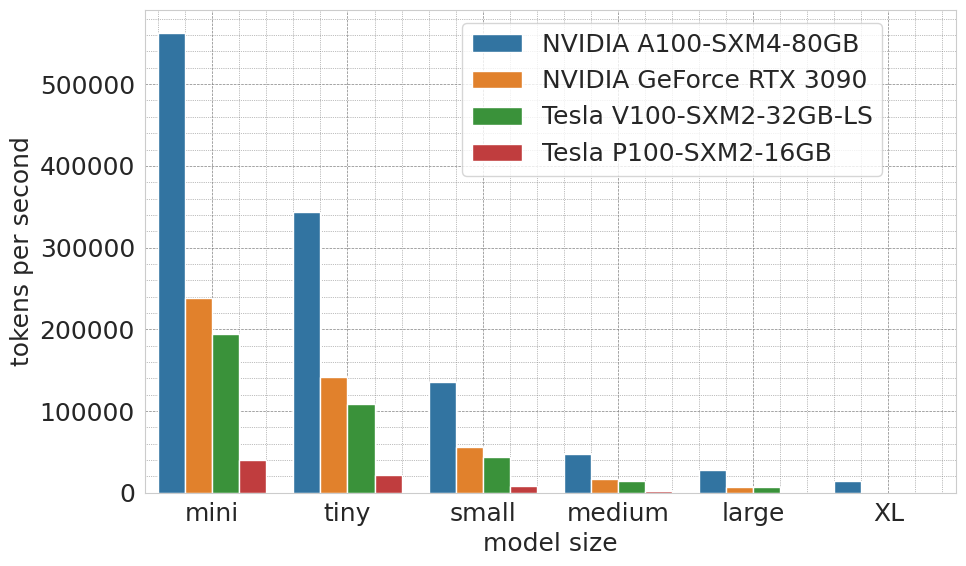

In [11]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=best_df, y='throughput', x='config', hue='device',
                order=['mini', 'tiny', 'small', 'medium', 'large', 'XL'],
                hue_order=['NVIDIA A100-SXM4-80GB',
                           'NVIDIA GeForce RTX 3090',
                           'Tesla V100-SXM2-32GB-LS',
                           'Tesla P100-SXM2-16GB',                           
                          ])
ax.set_xlabel('model size')
ax.set_ylabel('tokens per second')
#ax.set_yscale('log')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
plt.legend(bbox_to_anchor=(0.65, 1.0), loc='upper center', ncol=1)

#ax.set_yscale('log')
plt.tight_layout()
plt.savefig('throughputs_per_device.pdf')

## Plot Throughput Over Batch Sizes

/home/imanol/languini-kitchen/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/imanol/languini-kitchen/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/imanol/languini-kitchen/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/imanol/languini-kitchen/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

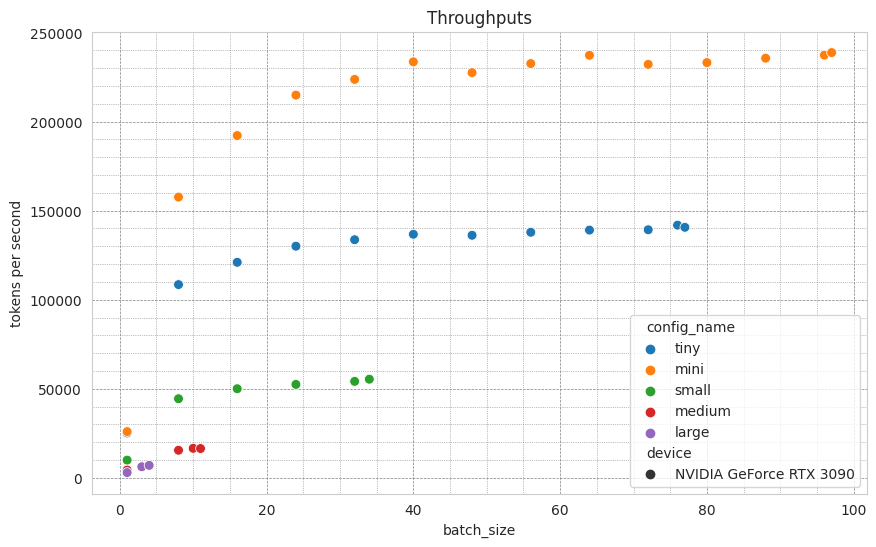

In [12]:
fdf = df[(df.vocab_size == vocab_size) & (df['tokens per second'] > 0) & (df.device.str.contains('3090'))]

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=fdf, y='tokens per second', x='batch_size', hue='config_name', style='device', s=50)
plt.title('Throughputs')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)

## Compute training steps for a specific number of gpu hours and batch size

In [13]:
gpu_hours = 6
config_name = 'small'
device = '3090'

In [14]:
fdf = df[(df.vocab_size == vocab_size) & (df.device.str.contains(device)) & (df['tokens per second'] > 0)]
tokens_per_second = fdf[fdf['config_name']==config_name]['tokens per second'].max()

fdf[(fdf['config_name']==config_name) & (fdf['tokens per second'] == tokens_per_second)][['config_name', 'vocab_size', 'batch_size', 'tokens per second', 'device']]

,config_name,vocab_size,batch_size,tokens per second,device
36,small,16384,34,55416,NVIDIA GeForce RTX 3090


In [15]:
print(tokens_per_second)

55416


In [16]:
tokens = gpu_hours * 60 * 60 * tokens_per_second
print(f"tokens to process: {tokens:,}")

tokens to process: 1,196,985,600


In [17]:
bsz = 128
seq_len = 512

steps = round(tokens / bsz / seq_len)
print(f"train steps: {steps:}")

train steps: 18265


In [18]:
n_workers = 1
gradient_accumulation_steps = 32
local_bsz = bsz / n_workers / gradient_accumulation_steps
print(f"effective local batch size: {local_bsz}")

effective local batch size: 4.0


In [19]:
print(f"{tokens / (n_workers * tokens_per_second) / 60 / 60:.2f} hours estimated running time")

6.00 hours estimated running time


In [20]:
df[
    (df.config_name == config_name) & 
    (df.vocab_size == vocab_size) &
    (df.device.str.contains('V100'))
][['config_name', 'batch_size', 'tokens per second', 'device']]

,config_name,batch_size,tokens per second,device
87,small,1,6107,Tesla V100-SXM2-32GB-LS
88,small,8,33393,Tesla V100-SXM2-32GB-LS
89,small,16,39670,Tesla V100-SXM2-32GB-LS
90,small,24,41569,Tesla V100-SXM2-32GB-LS
91,small,32,42554,Tesla V100-SXM2-32GB-LS
92,small,40,43285,Tesla V100-SXM2-32GB-LS
93,small,48,43480,Tesla V100-SXM2-32GB-LS
94,small,50,43839,Tesla V100-SXM2-32GB-LS
95,small,51,0,Tesla V100-SXM2-32GB-LS
96,small,52,0,Tesla V100-SXM2-32GB-LS
